In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from scipy.io import netcdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gsw
sns.set(context='talk',style='whitegrid',font_scale=1.3)
#from model_plotting import plot_snapshot,plot_snapshot_w
import scipy.linalg as la
# from spectra_module import spec2d

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
import bottleneck as bn
import random
import math

from deformtools.tools import alphabet
from deformtools.tools import *
from deformtools.io import *
from deformtools.methods import *

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [33]:
zgrid = pd.read_csv('../data/psom/zgrid.out',skipinitialspace=True,sep=' ',header=None)
zgrid=zgrid[1].values

dirr='../data/psom/full_08325.cdf'
time = dirr.split('/')[-1].split('_')[1].split('.')[0]

f =  netcdf.netcdf_file(dirr, 'r')
u = f.variables['u'][:][33, 1:321, 1:193]
v= f.variables['v'][:][33, 1:321, 1:193]
vor= f.variables['vor'][:][33, 1:321, 1:193]/gsw.f(17)
xc = f.variables['xc'][1:193]
yc = f.variables['yc'][1:321]

In [102]:
mode ='constant'
vor_5km = gaussian_filter(vor,sigma=1,mode=mode)
u_5km = gaussian_filter(u,sigma=1,mode=mode)
v_5km = gaussian_filter(v,sigma=1,mode=mode)
vor_10km = gaussian_filter(vor,sigma=2.5,mode=mode)
u_10km = gaussian_filter(u,sigma=2.5,mode=mode)
v_10km = gaussian_filter(v,sigma=2.5,mode=mode)

In [103]:
fu = interpolate.RectBivariateSpline(yc,xc,u)
fv = interpolate.RectBivariateSpline(yc,xc,v)
fzeta = interpolate.RectBivariateSpline(yc,xc,vor)
# 10km
fu5 = interpolate.RectBivariateSpline(yc,xc,u_5km)
fv5 = interpolate.RectBivariateSpline(yc,xc,v_5km)
fzeta5 = interpolate.RectBivariateSpline(yc,xc,vor_5km)
# 20km
fu10 = interpolate.RectBivariateSpline(yc,xc,u_10km)
fv10 = interpolate.RectBivariateSpline(yc,xc,v_10km)
fzeta10 = interpolate.RectBivariateSpline(yc,xc,vor_10km)

In [107]:
L = 2
S = 1
N = 5000
M = 3
xi,yi = make_n_hexs(L,S,N,M)

ui=np.zeros((N,M))
vi=np.zeros((N,M))
ui5=np.zeros((N,M))
vi5=np.zeros((N,M))
ui10=np.zeros((N,M))
vi10=np.zeros((N,M))
zeta_at_mean = np.zeros(N)
zeta_at_mean5 = np.zeros(N)
zeta_at_mean10 = np.zeros(N)
for i in range(N):
    for j in range(xi[1,:].size):
        ui[i,j] = fu(yi[i,j],xi[i,j])
        vi[i,j] = fv(yi[i,j],xi[i,j])
        ui5[i,j] = fu5(yi[i,j],xi[i,j])
        vi5[i,j] = fv5(yi[i,j],xi[i,j])
        ui10[i,j] = fu10(yi[i,j],xi[i,j])
        vi10[i,j] = fv10(yi[i,j],xi[i,j])
    zeta_at_mean[i]=  fzeta( np.mean(yi[i]),np.mean(xi[i]) )
    zeta_at_mean5[i]=  fzeta5( np.mean(yi[i]),np.mean(xi[i]) )
    zeta_at_mean10[i]=  fzeta10( np.mean(yi[i]),np.mean(xi[i]) )

In [108]:
vort_drifters=np.zeros(N)
vort_drifters5=np.zeros(N)
vort_drifters10=np.zeros(N)
for i in range(N):
    vort_drifters[i],_,_=least_square_method(xi[i,:],yi[i,:],ui[i,:],vi[i,:],'lstsq')
    vort_drifters5[i],_,_=least_square_method(xi[i,:],yi[i,:],ui5[i,:],vi5[i,:],'lstsq')
    vort_drifters10[i],_,_=least_square_method(xi[i,:],yi[i,:],ui10[i,:],vi10[i,:],'lstsq')
    
df_comparison = pd.DataFrame({'model_zeta':zeta_at_mean,'drifter_zeta':vort_drifters,
                         'model_zeta10':zeta_at_mean5,'drifter_zeta10':vort_drifters5,
                         'model_zeta20':zeta_at_mean10,'drifter_zeta20':vort_drifters10},index=np.arange(N) )

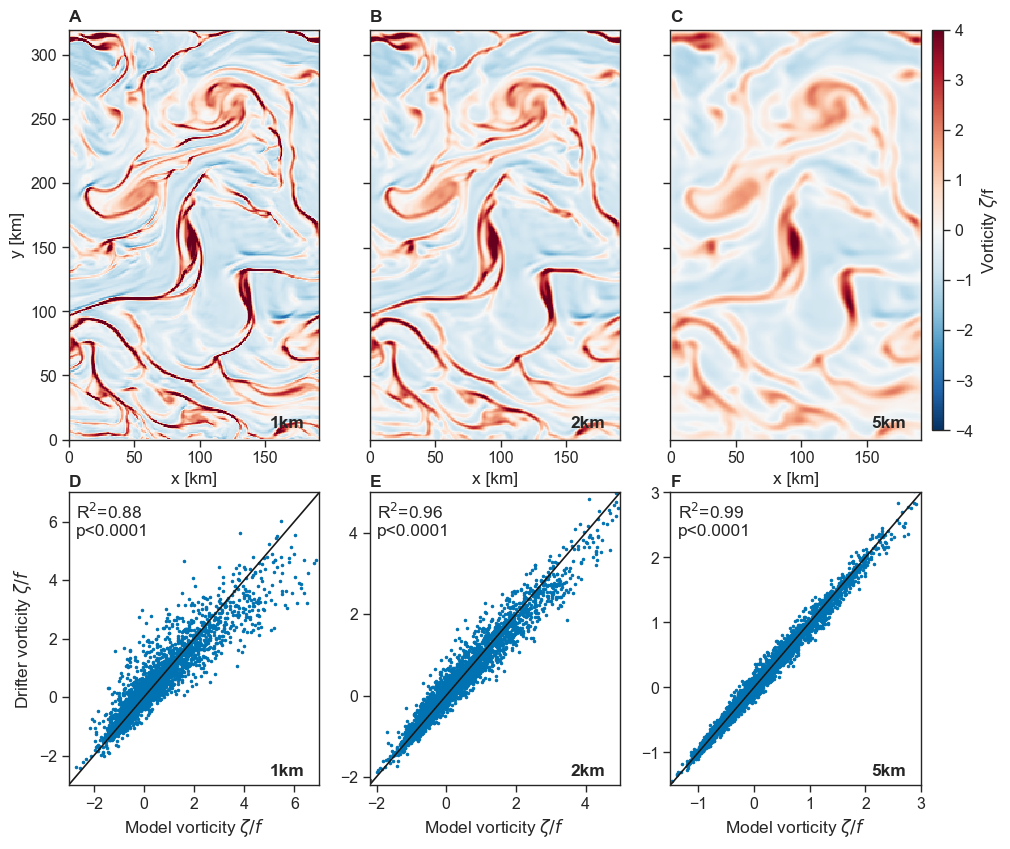

In [122]:
f = plt.figure(figsize=(11,10))
widths = [1,1,1]
heights = [1.4,1]
spec = f.add_gridspec(ncols=3,
                      nrows=2,
                      width_ratios=widths,
                      height_ratios=heights)

ax1 = f.add_subplot(spec[0, 0])
ax2 = f.add_subplot(spec[0, 1], sharey=ax1)
ax3 = f.add_subplot(spec[0, 2], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

h3 = ax1.pcolormesh(xc, yc, vor, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax2.pcolormesh(xc, yc, vor_5km, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax3.pcolormesh(xc, yc, vor_10km, cmap='RdBu_r',rasterized=True, vmin=-4,vmax=4)
ax1.set_yticks(np.arange(0,305,50))
ax1.set_xticks(np.arange(0,155,50))
ax2.set_xticks(np.arange(0,155,50))
ax3.set_xticks(np.arange(0,155,50))
ax1.set_ylabel('y [km]')
ax1.set_xlabel('x [km]')
ax2.set_xlabel('x [km]')
ax3.set_xlabel('x [km]')


a = ax3.get_position() # pos left, bottom, width, height
cbar_ax = f.add_axes([a.bounds[0]+a.bounds[2]+0.01, a.bounds[1], 0.01, a.bounds[3] ]) #
cbar = f.colorbar(h3, cax=cbar_ax,ticks=np.arange(-4,5),label='Vorticity $\zeta$/f')
cbar.ax.set_xticklabels(np.arange(-4,5))

ax4 = f.add_subplot(spec[1, 0])

ax4.scatter(x='model_zeta',y='drifter_zeta',data=df_comparison, s=3)
ax4.set_xlabel('Model vorticity $\zeta/f$')
ax4.set_ylabel('Drifter vorticity $\zeta/f$')
ax4.set_xlim(-3,7)
ax4.set_ylim(-3,7)
ax4.set_xticks(np.arange(-2,8,2))
ax4.set_yticks(np.arange(-2,8,2))
ax4.plot([-3,7],[-3,7], color='k')

ax5 = f.add_subplot(spec[1, 1])
ax5.scatter(x='model_zeta10',y='drifter_zeta10',data=df_comparison, s=3)
ax5.set_xlabel('Model vorticity $\zeta/f$')
# ax5.set_ylabel('Drifter vorticity $\zeta/f$')
ax5.set_xlim(-2.2,5)
ax5.set_ylim(-2.2,5)
ax5.set_xticks(np.arange(-2,6,2))
ax5.set_yticks(np.arange(-2,6,2))
ax5.plot([-2.2,5],[-2.2,5], color='k')

ax6 = f.add_subplot(spec[1, 2])
ax6.scatter(x='model_zeta20',y='drifter_zeta20',data=df_comparison, s=3)

ax6.set_xlabel('Model vorticity $\zeta/f$')
# ax6.set_ylabel('Drifter vorticity $\zeta/f$')
ax6.set_xlim(-1.5,3)
ax6.set_ylim(-1.5,3)
ax6.plot([-1.5,3],[-1.5,3], color='k')
ax6.set_yticks(np.arange(-1,4,1))
# ax6.set_yticklabels([])

ax1.annotate('1km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax2.annotate('2km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax3.annotate('5km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax4.annotate('1km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax5.annotate('2km',(0.8,0.03),xycoords='axes fraction',weight='bold')
ax6.annotate('5km',(0.8,0.03),xycoords='axes fraction',weight='bold')

r,p = pearsonr(df_comparison.model_zeta, df_comparison.drifter_zeta)
r2=r**2
ax4.annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.0001',(0.03,0.85),xycoords='axes fraction')

r,p = pearsonr(df_comparison.model_zeta10, df_comparison.drifter_zeta10)
r2=r**2
ax5.annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.0001',(0.03,0.85),xycoords='axes fraction')
r,p = pearsonr(df_comparison.model_zeta20, df_comparison.drifter_zeta20)
r2=r**2
# ax6.annotate(rf'R$^2$={r:2.2f}',(0.03,0.9),xycoords='axes fraction')
ax6.annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.0001',(0.03,0.85),xycoords='axes fraction')

# spec.tight_layout(f)
spec.update(hspace=0.15,wspace=0.2)

alphabet([ax1,ax2,ax3,ax4,ax5,ax6])

plt.savefig('../figures/performance_v2.pdf',bb_inches='tight',dpi=600)